In [1]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
from PIL import Image
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, Dropout, Flatten, Dense, Multiply, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [4]:
# Define directories
directory  = '../input/histopathologic-cancer-detection'  
labels_path = os.path.join(directory, 'train_labels.csv')
train_path = os.path.join(directory, 'train')
test_path = os.path.join(directory, 'test')

In [5]:
print('There are ',len(os.listdir(train_path)), 'training images and ',len(os.listdir(test_path)), 'testing images.')

There are  220025 training images and  57458 testing images.


In [6]:
# load the CSV file containing labels
labels = pd.read_csv(labels_path)

# create a DataFrame to match training data images with labels
train = pd.DataFrame({'path': glob(os.path.join(train_path, '*.tif'))}) 
train['id'] = train['path'].map(lambda x: os.path.splitext(os.path.basename(x))[0])  # Extract image ID to merge with training labels
train = train.merge(labels, on='id')  

# convert labels to strings
train['label'] = train['label'].astype(str)

# ensure paths are relative to train_path
train['path'] = train['path'].apply(lambda x: os.path.basename(x))

print(train.head())

                                           path  \
0  d43c081bafa286f9c1f7e921883f26ceafebc912.tif   
1  092d0eedebce504847715ee046b6ad74b57599b4.tif   
2  b0d2582c6218a8764323fc940b41312282b99bf4.tif   
3  187c99df762f13f99818e5593d4bab4c6577e7e3.tif   
4  7c5270c83837de5a5cbb2dca511559dc39d19d53.tif   

                                         id label  
0  d43c081bafa286f9c1f7e921883f26ceafebc912     1  
1  092d0eedebce504847715ee046b6ad74b57599b4     0  
2  b0d2582c6218a8764323fc940b41312282b99bf4     0  
3  187c99df762f13f99818e5593d4bab4c6577e7e3     1  
4  7c5270c83837de5a5cbb2dca511559dc39d19d53     1  


## Data Exploration

In [7]:
# check for null values
print('There are ',train.isnull().sum().sum(), ' null values')
# check for duplicates
print('There are ', train.duplicated().sum(),' duplicated images')

There are  0  null values
There are  0  duplicated images


In [8]:
# randomly select one image path
image_path = random.choice(train['path'].values)
# full path to the image
full_image_path = os.path.join(train_path, image_path)
# Load the selected image 
selected_image = cv2.imread(full_image_path)

print('Image shape is ', selected_image.shape)
print('The maximum number of pixels is ', selected_image.max())

Image shape is  (96, 96, 3)
The maximum number of pixels is  255


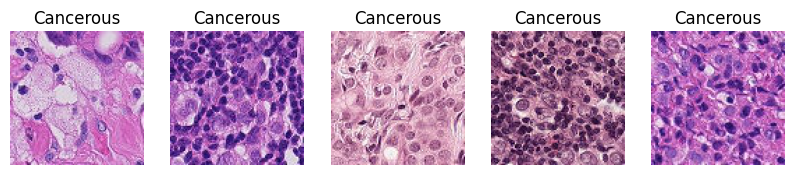

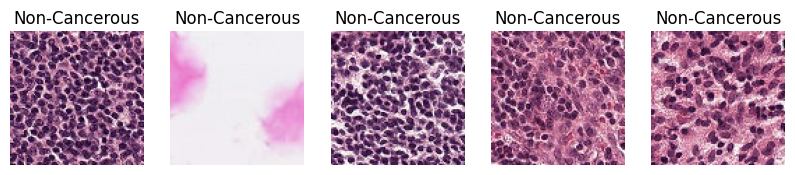

In [9]:
# Separate cancerous and non-cancerous data
cancerous = train[train['label'] == '1']['id'].sample(n=5).values  # Treat labels as strings
noncancerous = train[train['label'] == '0']['id'].sample(n=5).values

cancerous_images = []
for id in cancerous:
    image_path = os.path.join(train_path, id + '.tif')
    cancerous_images.append(Image.open(image_path))

noncancerous_images = []
for id in noncancerous:
    image_path = os.path.join(train_path, id + '.tif')
    noncancerous_images.append(Image.open(image_path))

plt.figure(figsize=(10, 5))
for i, image in enumerate(cancerous_images):
    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.title('Cancerous')
    plt.axis('off')
plt.show()

plt.figure(figsize=(10, 5))
for i, image in enumerate(noncancerous_images):
    plt.subplot(1, 5, i+1)
    plt.imshow(image)
    plt.title('Non-Cancerous')
    plt.axis('off')
plt.show()

Positive labels in training data: 40.50%


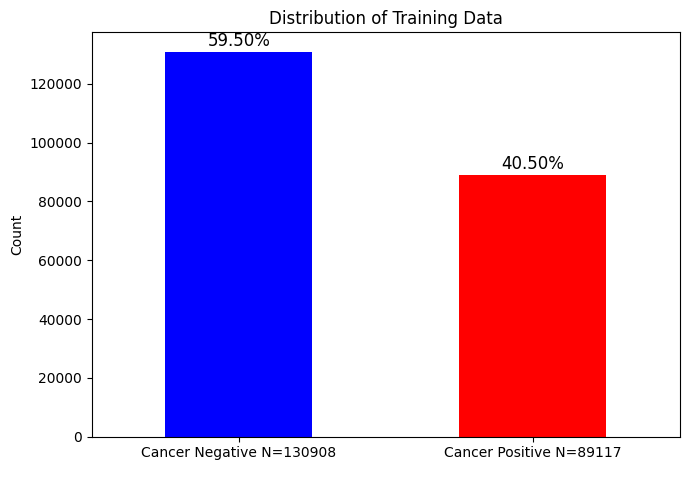

In [10]:
# Counts for each class
label_counts = labels['label'].value_counts()

# Calculate the percentages of each class
positive_percentage = label_counts[1] / (label_counts[0] + label_counts[1])
print(f'Positive labels in training data: {positive_percentage:.2%}')

# Bar plot 
plt.figure(figsize=(7, 5))
ax = label_counts.sort_index().plot(kind='bar', color=['blue', 'red'])

plt.xticks([0, 1], labels=[f"Cancer Negative N={label_counts[0]}", f"Cancer Positive N={label_counts[1]}"], rotation=0)

for i, count in enumerate(label_counts):
    percentage = count / label_counts.sum() * 100
    ax.text(i, count + 500, f'{percentage:.2f}%', ha='center', va='bottom', fontsize=12)

plt.title(f'Distribution of Training Data')
plt.ylabel('Count')
plt.xlabel(" ")
plt.tight_layout()

# Save plot to kaggle output directory
#plt.savefig('/kaggle/working/training_data_distribution.png', dpi=300)

plt.show()

## Data Generators with Gaussian Smoothing
Gaussian smoothing removes noise while preserving edges.

In [11]:
def gaussian_smooth(image):
    # Convert image to unit8
    image = (image * 255).astype(np.uint8)

    #Convert image to RGB
    if image.shape[-1] == 1:
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Gaussian smoothing (blur)
    image = cv2.GaussianBlur(image, (3, 3), 0)

    # Convert float 32 and range of [0,1]
    return image.astype(np.float32) / 255.0


In [13]:
# Split the data into 80% training and 20% validation sets
train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)

# Data generator for training images
train_datagen = ImageDataGenerator(
    rescale=1./255,  # scale images from integers 0-255 to 0-1
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True, 
    #preprocessing_function=gaussian_smooth
)

# Data generator for validation images without augmentation
validation_datagen = ImageDataGenerator(
    rescale=1./255,  # scale images from integers 0-255 to 0-1
    #preprocessing_function=gaussian_smooth
)

batch_size = 16

# Generator for the training set
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_path,
    x_col='path',
    y_col='label',
    target_size=(96, 96), # image shape
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

# Generator for the validation set
validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=val_df,  
    directory=train_path,
    x_col='path',
    y_col='label',
    target_size=(96, 96),
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


## Model with Spacial Attention
Spatial attention mechanisms help the network to selectively focus on specific regions within an image while suppressing less relevant areas. This model will also use a learning rate scheduler to decrease the learning rate during training if it detects the model isn’t improving enough.

In [14]:
def spatial_attention_block(input_tensor, kernel_size=7):
    # Generates attention features through a separate pathway
    attention = Conv2D(filters=1, kernel_size=kernel_size, padding='same', activation='sigmoid')(input_tensor)
    #attention = BatchNormalization()(attention)

    # Apply attention to input
    refined_features = Multiply()([input_tensor, attention])

    return refined_features

In [15]:
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.5, # 50% Reduction in learning Rate
    patience = 3, # If no improvement after 3 epochs
    verbose = 1,
    min_lr = 1e-6 # minimum learning rate not to go below
)

In [16]:
# Define input
inputs = Input(shape=(96, 96, 3))

x = Conv2D(64, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001))(inputs)
# Spatial attention layer
# Using kernel_size=9 then kernel_size=3 to capture both global and local spatial dependencies
x = spatial_attention_block(x, kernel_size=9)
x = spatial_attention_block(x, kernel_size=3)
x = Dropout(0.1)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(128, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.15)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(256, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

x = Conv2D(512, (3, 3), padding='same', activation='relu', kernel_regularizer=l2(0.001))(x)
# 2nd spatial attention layer, allows the model to re-focus after deep feature extraction
x = spatial_attention_block(x, kernel_size=9)
x = spatial_attention_block(x, kernel_size=3)
x = Dropout(0.25)(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2))(x)

# Global Average Pooling to reduce spatial dimensions
x = GlobalAveragePooling2D()(x)

# Fully connected layers
x = Dense(256)(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)

# Output layer
outputs = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001))(x)

# Build model
model_spatial = Model(inputs, outputs)

I0000 00:00:1745955888.394929      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745955888.395640      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [17]:
model_spatial.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 96, 96, 3)      │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 96, 96, 64)     │          1,792 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 96, 96, 1)      │          5,185 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply (Multiply)       │ (None, 96, 96, 64)     │              0 │ conv2d[0][0],          │
│                           │                        │                │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 96, 96, 1)      │            577 │ multiply[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)     │ (None, 96, 96, 64)     │              0 │ multiply[0][0],        │
│                           │                        │                │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout (Dropout)         │ (None, 96, 96, 64)     │              0 │ multiply_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 96, 96, 64)     │            256 │ dropout[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 48, 48, 64)     │              0 │ batch_normalization[0… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 48, 48, 128)    │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 48, 48, 128)    │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 48, 48, 128)    │            512 │ dropout_1[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 24, 24, 128)    │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 24, 24, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, 24, 24, 256)    │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 24, 24, 256)    │          1,024 │ dropout_2[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 1,739,269 (6.63 MB)

 Trainable params: 1,736,837 (6.63 MB)

 Non-trainable params: 2,432 (9.50 KB)

In [19]:
model_spatial.compile(
    optimizer=Adam(learning_rate=0.0002),
    loss='binary_crossentropy',
    metrics=['accuracy', 'auc']
)

Keras was prematurely ending training and moving to the next epoch, most likely because Keras didn't have enough data to complete all the steps per epoch. Therefor Keras was allowed to automatically determine the number of steps_per_epoch and Validation_stpes.

In [20]:
#steps_per_epoch = len(train_df)//batch_size
#validation_steps = len(val_df)//batch_size

hist_spatial = model_spatial.fit(
    train_generator,
    #steps_per_epoch = steps_per_epoch, 
    validation_data = validation_generator,
    #validation_steps = validation_steps,
    epochs = 20,
    callbacks=[reduce_lr]
)

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1745956186.227090     104 service.cc:148] XLA service 0x7e07d0002670 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745956186.227884     104 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745956186.227907     104 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745956187.014375     104 cuda_dnn.cc:529] Loaded cuDNN version 90300


    2/11002 ━━━━━━━━━━━━━━━━━━━━ 9:44 53ms/step - accuracy: 0.5000 - auc: 0.4169 - loss: 1.5301   

I0000 00:00:1745956197.619004     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11002/11002 ━━━━━━━━━━━━━━━━━━━━ 2057s 185ms/step - accuracy: 0.8209 - auc: 0.8879 - loss: 0.6697 - val_accuracy: 0.7401 - val_auc: 0.7209 - val_loss: 1.1886 - learning_rate: 2.0000e-04
Epoch 2/20
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 773s 70ms/step - accuracy: 0.8806 - auc: 0.9417 - loss: 0.3599 - val_accuracy: 0.8256 - val_auc: 0.9057 - val_loss: 0.4663 - learning_rate: 2.0000e-04
Epoch 3/20
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 729s 66ms/step - accuracy: 0.8917 - auc: 0.9504 - loss: 0.3337 - val_accuracy: 0.8776 - val_auc: 0.9519 - val_loss: 0.3408 - learning_rate: 2.0000e-04
Epoch 4/20
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 675s 61ms/step - accuracy: 0.8987 - auc: 0.9557 - loss: 0.3175 - val_accuracy: 0.8430 - val_auc: 0.9395 - val_loss: 0.4360 - learning_rate: 2.0000e-04
Epoch 5/20
11002/11002 ━━━━━━━━━━━━━━━━━━━━ 649s 59ms/step - accuracy: 0.9017 - auc: 0.9580 - loss: 0.3091 - val_accuracy: 0.7994 - val_auc: 0.8975 - val_loss: 0.5167 - learning_rate: 2.0000e-04
Epoch 6/20
11002/11002 ━━━━━━━━━━━

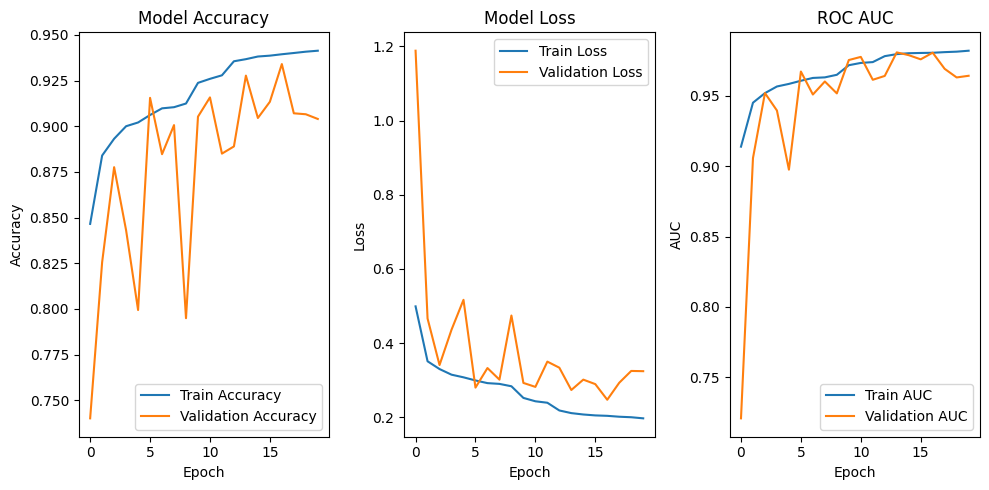

In [21]:
plt.figure(figsize=(10, 5))

# accuracy plot
plt.subplot(1, 3, 1)
plt.plot(hist_spatial.history['accuracy'], label='Train Accuracy')
plt.plot(hist_spatial.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend(loc='lower right')

# loss plot
plt.subplot(1, 3, 2)
plt.plot(hist_spatial.history['loss'], label='Train Loss')
plt.plot(hist_spatial.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend(loc='upper right')

# AUC plot
plt.subplot(1, 3, 3)
plt.plot(hist_spatial.history['auc'], label='Train AUC')
plt.plot(hist_spatial.history['val_auc'], label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('ROC AUC')
plt.legend(loc='lower right')

plt.tight_layout()
# Save plot to kaggle output directory
plt.savefig('/kaggle/working/cnn_training_results.png', dpi=300)
plt.show()

## Confusion Matrix

2751/2751 ━━━━━━━━━━━━━━━━━━━━ 48s 17ms/step


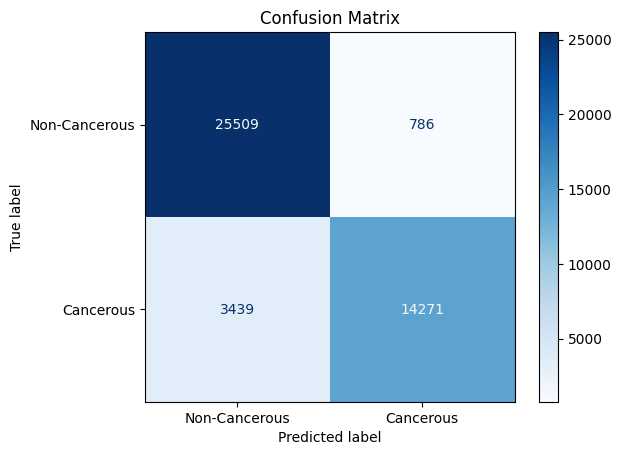

In [22]:
# calculations for confusion matrix
true_labels = validation_generator.classes
pred_probabilities = model_spatial.predict(validation_generator, steps=len(validation_generator), verbose=1)

# for binary classification get predicted classes based on probability threshold of 0.5
pred_classes = (pred_probabilities > 0.5).astype(int)

# confusion matrix
cm = confusion_matrix(true_labels, pred_classes)

# plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Cancerous', 'Cancerous'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')

# Save plot to kaggle output directory
plt.savefig('/kaggle/working/cnn_training_confusion.png', dpi=300)
plt.show()